<a href="https://colab.research.google.com/github/ravishankarramakrishnan/Deep_Learning_Practice/blob/master/Tweet_Emotion_Recognition_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
# Install Huggingface NLP Package
!pip install nlp 

     |████████████████████████████████| 1.7MB 4.3MB/s 
     |████████████████████████████████| 245kB 20.9MB/s 
     |████████████████████████████████| 17.3MB 199kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [2]:
# Importing the Libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
%matplotlib inline

print('Using TensorFlow version', tf.__version__)

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow version 2.3.0


In [4]:
# Define a Function to plot Training and Validation Accuracy/Loss
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Define a Function to plot Confusion Matrix - Multiclass Metrics
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [5]:
# Loading the Dataset

data = nlp.load_dataset('emotion') # For Twitter Emotion Dataset - By Huggingface

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [6]:
# See the Dataset
data

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
# Access the Sets

train = data['train']
test = data['test']
val = data['validation']

In [9]:
# See a Sample of Training Data - It is of Ordered Dictionary
train[:5]

OrderedDict([('label', ['sadness', 'sadness', 'anger', 'love', 'anger']),
             ('text',
              ['i didnt feel humiliated',
               'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
               'im grabbing a minute to post i feel greedy wrong',
               'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
               'i am feeling grouchy'])])

In [10]:
# Function to get tweets - Data

def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [12]:
# Get the Tweets and Labels for Training Set

tweets, labels = get_tweet(train)

# Validate the tweet and the label
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

Tensorflow comes with built in Tokenizer. Tokenization is the process of converting Raw text into numbers so that it can be fed to the Model. Tokenizer creates a corpus of All words that occur in a Dataset and gives each unique word, a unique number(token).

Out of Vocabulary Tokens are represented as \<UNK>.

Most common (Frequently used) N words are tokenized and the remaining words are ignored, represented as \<UNK>.

In [13]:
# Import tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
# Instantiate the Tokenizer

tokenizer = Tokenizer(num_words = 10000, lower= True, oov_token= '<UNK>')

# Mapping from words to Numeric Tokens

tokenizer.fit_on_texts(tweets)

In [16]:
# Validate by checking the Sequences

print(tweets[1])
print( tokenizer.texts_to_sequences([tweets[1]]) )

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
[[2, 40, 101, 60, 8, 15, 494, 5, 15, 3496, 553, 32, 60, 61, 128, 148, 76, 1480, 4, 22, 1255]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

64


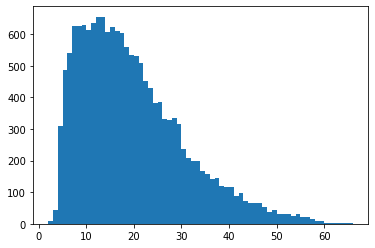

In [20]:
# We Need fixed Input Shape, So we pad and Truncate the Sequences
lengths = [len(t.split(' ')) for t in tweets] # Get Length of Words in a Tweet

print(len(set(lengths))) # Same as no of Unique Lengths in the Dataset
# Plot a Histogram to Visualize the Distribution of Lengths
plt.hist(lengths, bins= len(set(lengths)));

In [21]:
# Truncate and Pad
maxlen = 45

# Import Tensorflow Function
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define a Function to get sequences
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    # Padding the Sequence
    padded = pad_sequences(sequences, truncating= 'post', padding= 'post', maxlen= maxlen) # Truncating & Padding happens at End of a Sequence
    return padded

In [22]:
# Get the Padded sequence using the above function

padded_train_seq = get_sequences(tokenizer= tokenizer, tweets= tweets)

# Validate the First example
padded_train_seq[0] 

# It is a Vector of 50 Dimensions

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [23]:
# See the Classes
classes = set(labels)
print(classes)

{'sadness', 'joy', 'fear', 'surprise', 'anger', 'love'}


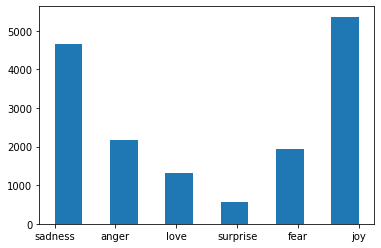

In [25]:
# Visualize the Classes
plt.hist(labels, bins= 11) # For 1 Gap between 6 classes
plt.show()

In [30]:
# We have a Class Imbalance Problem

# Create Dictionary to convert class names to numeric Values
class_to_index = dict((c, i) for i, c in enumerate(classes))
#index_to_class = dict((v, k) for v, k in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items()) 
print(class_to_index)
print(index_to_class)

{'sadness': 0, 'joy': 1, 'fear': 2, 'surprise': 3, 'anger': 4, 'love': 5}
{0: 'sadness', 1: 'joy', 2: 'fear', 3: 'surprise', 4: 'anger', 5: 'love'}


In [32]:
# Write a Lambda (anonymous) function to convert names to index
names_to_ids = lambda labels: np.array([ class_to_index.get(x) for x in labels ]) # Get the Index from the Dictionary

In [33]:
# Apply the Function for Label conversion
train_labels = names_to_ids(labels)

# Validate the Conversion
for i in range(10):
    print(labels[i], '---->' ,train_labels[i])

sadness ----> 0
sadness ----> 0
anger ----> 4
love ----> 5
anger ----> 4
sadness ----> 0
surprise ----> 3
fear ----> 2
joy ----> 1
love ----> 5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 16)            160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 45, 40)            5920      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


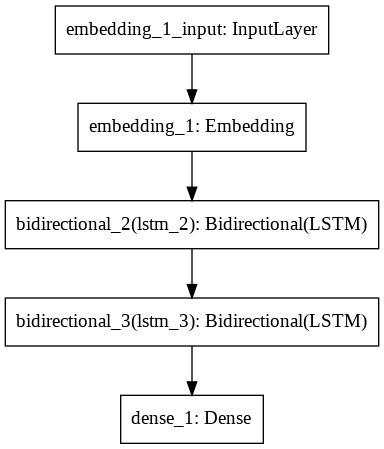

In [36]:
# Building the Model

model = tf.keras.models.Sequential([
              
              # Layers to Pass. Each word is represented as 16 dimensional vectors
              tf.keras.layers.Embedding(input_dim= 10000, output_dim= 16, input_length= maxlen),
              # RNN part begins. Use Bidirectional LSTM Layer. Context in LSTM can go from both Left to Right and Right to Left
              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences= True)),
              # The Outputs are fed into another Bidirectional LSTM Layer
              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units= 20)), # 20 cells
              # RNN Part over. Finally add Dense Layer
              tf.keras.layers.Dense(units= 6, activation= "softmax")
])

# Compile the Model
model.compile(
    loss= "sparse_categorical_crossentropy", # For Multiclass we use categorical Crossentropy. As our Target is not One Hot Encoded, we use sparse
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=2e-05),
    metrics= ['accuracy']
)

# Get the Model Summary
model.summary()

# Plot the Model
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [39]:
# Preparing the Validation Set

# Get the Data
val_tweets, val_labels = get_tweet(val)

# Get the Validation Sequences
val_seq = get_sequences(tokenizer, val_tweets)

# Encode the Labels - Use built Anonymous Function
val_labels_mapped = names_to_ids(val_labels)

# Validate
print(val_tweets[0], '--->', val_seq[0])
print(val_labels[0], '--->', val_labels_mapped[0])

im feeling quite sad and sorry for myself but ill snap out of it soon ---> [ 17   8 157 260   4 343  16  51  19 212   1  50  10  13 533   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
sadness ---> 0


In [41]:
# Training the Model

history = model.fit(padded_train_seq, train_labels,
                    validation_data = (val_seq, val_labels_mapped),
                    epochs= 20,
                    callbacks= [
                                 tf.keras.callbacks.EarlyStopping(monitor= "val_accuracy", patience= 3)
                    ])

Epoch 1/20
500/500 [==============================] - 9s 17ms/step - loss: 1.4496 - accuracy: 0.3989 - val_loss: 1.0951 - val_accuracy: 0.5810
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 0.7655 - accuracy: 0.7308 - val_loss: 0.6175 - val_accuracy: 0.8015
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3923 - accuracy: 0.8711 - val_loss: 0.5008 - val_accuracy: 0.8370
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2472 - accuracy: 0.9185 - val_loss: 0.4406 - val_accuracy: 0.8555
Epoch 5/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1760 - accuracy: 0.9445 - val_loss: 0.4677 - val_accuracy: 0.8750
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1325 - accuracy: 0.9584 - val_loss: 0.3951 - val_accuracy: 0.8805
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1162 - accuracy: 0.9646 - val_loss: 0.5103 - val_accuracy: 0.8700

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

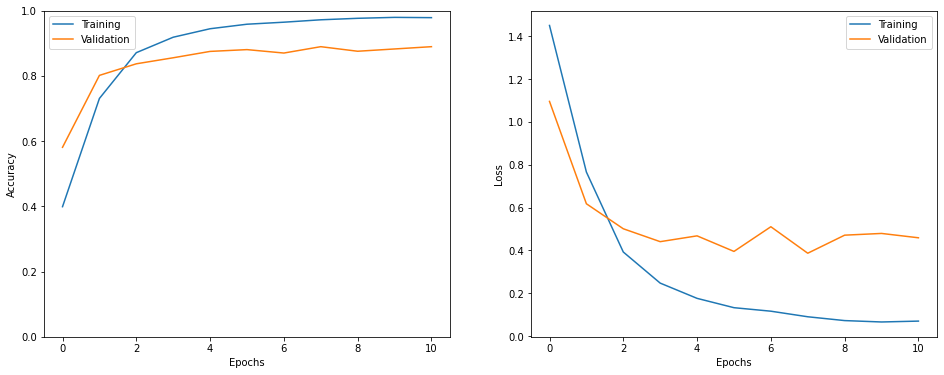

In [42]:
# Visualize using pre created Accuracy/Loss Function
show_history(history)

In [43]:
# Evaluating Performance of Models on the Test Set

# Get the Data
test_tweets, test_labels = get_tweet(test)

# Get the Validation Sequences
test_seq = get_sequences(tokenizer, test_tweets)

# Encode the Labels - Use built Anonymous Function
test_labels_mapped = names_to_ids(test_labels)

# Validate
print(test_tweets[0], '--->', test_seq[0])
print(test_labels[0], '--->', test_labels_mapped[0])

im feeling rather rotten so im not very ambitious right now ---> [  17    8  203  715   15   17   26   46 5595  114   58    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
sadness ---> 0


In [44]:
# Evaluation
eval = model.evaluate(test_seq, test_labels_mapped)

63/63 [==============================] - 0s 7ms/step - loss: 0.4004 - accuracy: 0.8895


In [48]:
# Prediction of Random Examples
i = np.random.randint(0, len(test_labels_mapped) - 1) # Randomly select an Index between 0 and len(test)-1

print("Sentence:\n", test_tweets[i])
print("Actual Emotion:\n", index_to_class[test_labels_mapped[i]])

# Prediction
p = model.predict(np.expand_dims(test_seq[i], axis= 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print("Predicted Emotion:\n", pred_class)
# You need to Expand the Dimensions of the sequence - Makes test input in Appropriate shape 

Sentence:
 i cant walk into a shop anywhere where i do not feel uncomfortable
Actual Emotion:
 fear
Predicted Emotion:
 fear


In [49]:
# Sample Visual
print(test_seq[1])
np.expand_dims(test_seq[1], axis= 0)

[ 17   1  11 243  37   2   3 469   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


array([[ 17,   1,  11, 243,  37,   2,   3, 469,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]], dtype=int32)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


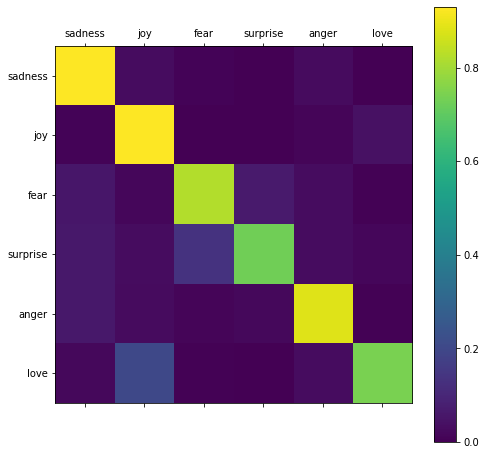

In [50]:
# Get all the Predictions
preds = model.predict_classes(test_seq) # Predict classes 

# Plot the Heatmap Confusion matrix via Prewritten Function
show_confusion_matrix(test_labels_mapped, preds, classes= list(classes))

In [54]:
# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# Show Confusion Matrix
confusion_matrix(test_labels_mapped, preds)

array([[540,  17,   6,   1,  16,   1],
       [  7, 646,   2,   1,  10,  29],
       [ 13,   4, 184,  15,   7,   1],
       [  4,   2,   9,  48,   2,   1],
       [ 16,   7,   3,   5, 243,   1],
       [  3,  32,   1,   0,   5, 118]])

In [56]:
# Print the Classification Report
print(classification_report(test_labels_mapped, preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       581
           1       0.91      0.93      0.92       695
           2       0.90      0.82      0.86       224
           3       0.69      0.73      0.71        66
           4       0.86      0.88      0.87       275
           5       0.78      0.74      0.76       159

    accuracy                           0.89      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000

